In [ ]:
# 0. Setup & Imports
# We don't need torchmetrics; sklearn handles metrics & plots.
# Using --no-deps prevents pip resolver from touching Kaggle's base sklearn/numpy.
!pip -q install --no-deps timm==1.0.9 albumentations==1.4.8 opendatasets==0.1.22

# If you previously installed conflicting packages in this session, you can optionally run:
# !pip -q uninstall -y category-encoders cesium sklearn-compat || true

import os, random, json
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

import timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
#Configuration

CFG = SimpleNamespace(
    DATA_DIR=Path('/kaggle/input/brain-tumor-mri-multi-class-dataset/multi_class_dataset'),
    WORK_DIR=Path('/kaggle/working'),

    IMG_SIZE=224,
    BATCH_SIZE=32,
    EPOCHS=20,
    LR=3e-4,
    NUM_WORKERS=2,
    VAL_SPLIT=0.15,
    SEED=42,

    # CGAN (preprocessing for class balance)
    USE_CGAN=True,      # set False to skip GAN and run faster
    CGAN_EPOCHS=15,
    LATENT_DIM=128,
    GEN_FACTOR=1.0,     # generate to match majority class
    MAX_SYNTH_PER_CLASS=3000,

    # Models to train (timm names)
    MODELS=[
        ('convnext_tiny', 'convnext_tiny.fb_in22k_ft_in1k'),
        ('coatnet', 'coatnet_0_rw_224'),
        ('vit_resnet_hybrid', 'vit_base_r50_s16_224'),
    ],

    DEVICE='cuda' if torch.cuda.is_available() else 'cpu',
)

# Reproducibility
random.seed(CFG.SEED); np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(CFG.SEED)

print("Device:", CFG.DEVICE)



Device: cuda


Class distribution (before):


,id,class,count,percent
0,1,healthy,6704,41.21
1,2,glioma,3325,20.44
2,3,meningioma,3266,20.07
3,4,pituitary,2974,18.28


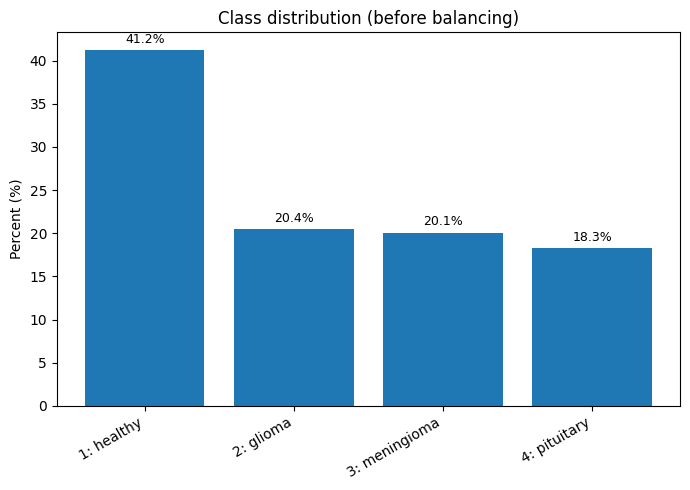

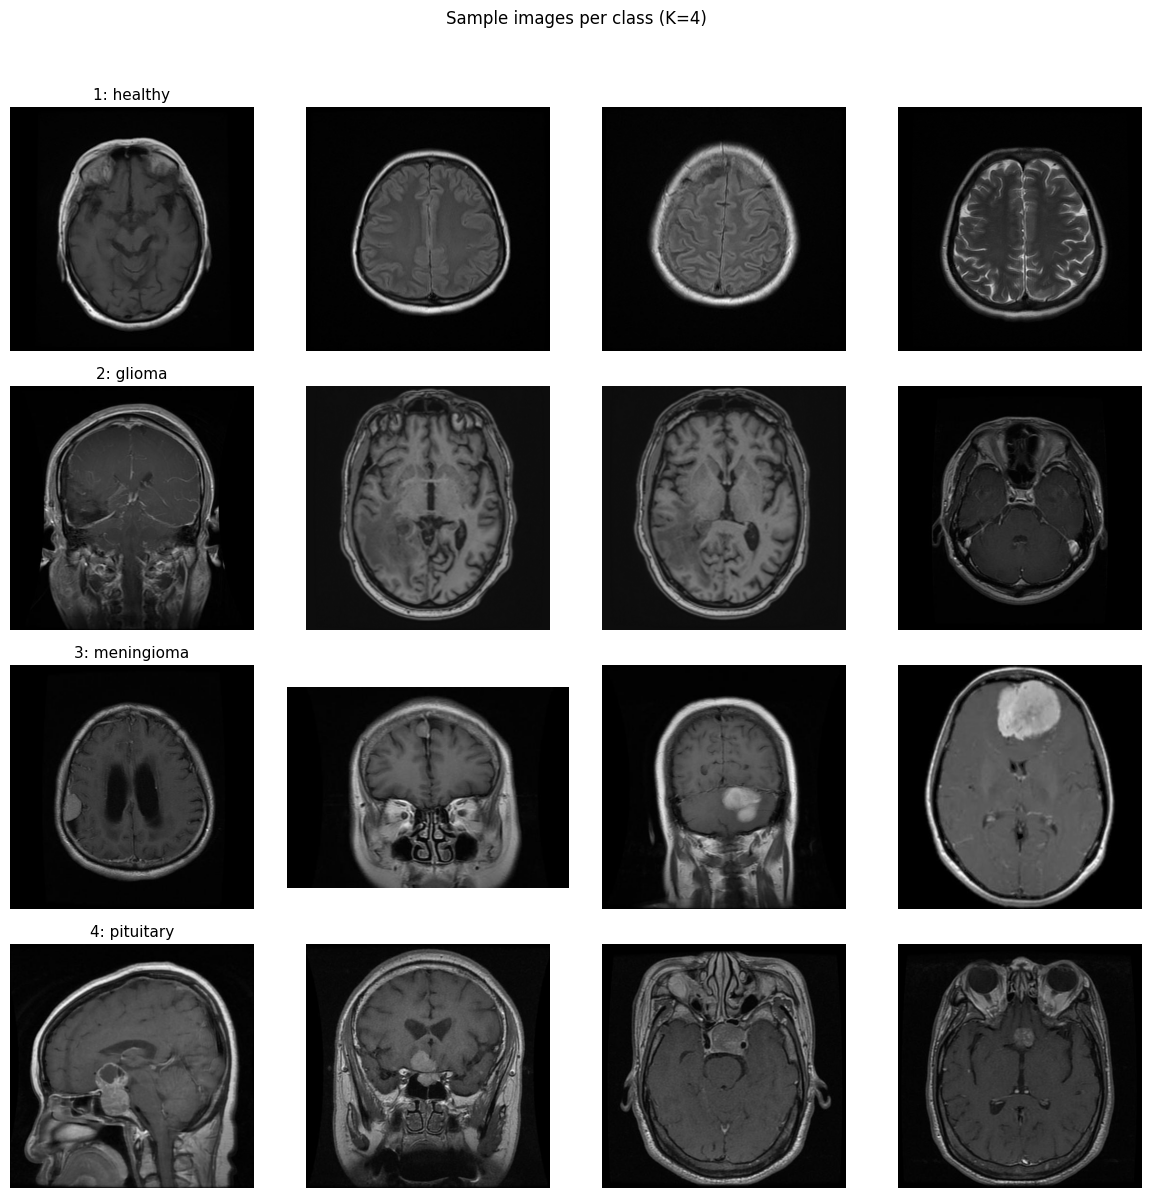

In [ ]:
#EDA

def is_image(p: Path):
    return p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def discover_dataset(root: Path):
    """Return (paths, labels) assuming ImageFolder: root/<class>/*"""
    paths, labels = [], []
    for cls in sorted([d for d in root.iterdir() if d.is_dir()]):
        for p in cls.rglob('*'):
            if p.is_file() and is_image(p):
                paths.append(p)
                labels.append(cls.name)
    return paths, labels

# Load & basic checks
assert CFG.DATA_DIR.exists(), f"DATA_DIR not found: {CFG.DATA_DIR}"
img_paths, img_labels = discover_dataset(CFG.DATA_DIR)
assert len(img_paths) > 0, f"No images found under {CFG.DATA_DIR}"

# ---------- FORCE 'healthy' to be ID = 1 ----------
all_classes = sorted(list(set(img_labels)))
if 'healthy' in all_classes:
    classes = ['healthy'] + [c for c in all_classes if c != 'healthy']
else:
    classes = all_classes  # fallback if no 'healthy' class

# Mappings
class_to_idx  = {c: i for i, c in enumerate(classes)}      # 0..N-1 for training
class_to_id1  = {c: i+1 for i, c in enumerate(classes)}    # 1..N for reporting (healthy=1)
idx_to_class  = {i: c for c, i in class_to_idx.items()}

# Counts and percentages (ordered with healthy first)
counts = pd.Series(img_labels).value_counts().reindex(classes)
total  = counts.sum()
pct    = (counts / total * 100).round(2)

before_df = pd.DataFrame({
    "id": [class_to_id1[c] for c in classes],
    "class": classes,
    "count": counts.values,
    "percent": pct.values
})
print("Class distribution (before):")
display(before_df)

# Bar chart (percentages) with "id: class" labels
labels = [f"{class_to_id1[c]}: {c}" for c in classes]
plt.figure(figsize=(7,5))
bars = plt.bar(labels, pct.values)
plt.title("Class distribution (before balancing)")
plt.ylabel("Percent (%)")
plt.xticks(rotation=30, ha='right')
for b, v in zip(bars, pct.values):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5, f"{v:.1f}%",
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

#Show K sample images per class
K = 4
files_by_class = {c: [] for c in classes}
for p, lab in zip(img_paths, img_labels):
    files_by_class[lab].append(p)

plt.figure(figsize=(3*K, 3*len(classes)))
for r, cname in enumerate(classes):
    if len(files_by_class[cname]) == 0:
        continue
    sample = random.sample(files_by_class[cname], k=min(K, len(files_by_class[cname])))
    for ci, fp in enumerate(sample):
        ax = plt.subplot(len(classes), K, r*K + ci + 1)
        ax.imshow(Image.open(fp).convert('RGB'))
        ax.axis('off')
        if ci == 0:
            ax.set_title(f"{class_to_id1[cname]}: {cname}", fontsize=11)
plt.suptitle(f"Sample images per class (K={K})", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
# 3. Dataset & Transforms

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

valid_tfms = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

class ImageDataset(Dataset):
    def __init__(self, files, labels, transform):
        self.files = files; self.labels = labels; self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]; x = Image.open(p).convert('RGB')
        x = self.transform(x); y = class_to_idx[self.labels[idx]]
        return x, y

# Stratified train/val split by labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=CFG.VAL_SPLIT, random_state=CFG.SEED)
train_idx, val_idx = next(sss.split(img_paths, img_labels))
train_files = [img_paths[i] for i in train_idx]; train_labels = [img_labels[i] for i in train_idx]
val_files   = [img_paths[i] for i in val_idx];   val_labels   = [img_labels[i] for i in val_idx]



In [ ]:
#cGAN

class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_size):
        super().__init__()
        self.embed = nn.Embedding(n_classes, n_classes)           # label embedding (one-hot-like)
        self.fc = nn.Linear(latent_dim + n_classes, 8*8*256)      # project noise+label to feature map
        self.net = nn.Sequential(                                 # upsample to image
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1),  nn.BatchNorm2d(64),  nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1),   nn.BatchNorm2d(32),  nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,2,1),    nn.Tanh(),
        )
        self.img_size = img_size

    def forward(self, z, labels):
        x = torch.cat([z, self.embed(labels)], dim=1)
        x = self.fc(x).view(-1,256,8,8)
        x = self.net(x)
        return F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

class Discriminator(nn.Module):
    def __init__(self, n_classes, img_size):
        super().__init__()
        self.embed = nn.Embedding(n_classes, n_classes)
        self.conv = nn.Sequential(
            nn.Conv2d(3+n_classes,64,4,2,1),  nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128,4,2,1),          nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,256,4,2,1),         nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256,512,4,2,1),         nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear((img_size//16)*(img_size//16)*512,1)

    def forward(self, img, labels):
        b,_,h,w = img.shape
        emb = self.embed(labels).view(b,-1,1,1).expand(b,-1,h,w)
        x = torch.cat([img, emb], dim=1)
        x = self.conv(x).view(b,-1)
        return self.fc(x)


In [ ]:
#Train CGAN + Synthesis Helpers

def train_cgan(train_files, train_labels):
    device = CFG.DEVICE; n_classes = len(classes)
    G = Generator(CFG.LATENT_DIM, n_classes, CFG.IMG_SIZE).to(device)
    D = Discriminator(n_classes, CFG.IMG_SIZE).to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
    bce = nn.BCEWithLogitsLoss()

    r_tfms = transforms.Compose([
        transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    class CGANDataset(Dataset):
        def __init__(self, files, labels): self.files=files; self.labels=labels
        def __len__(self): return len(self.files)
        def __getitem__(self, idx):
            x = Image.open(self.files[idx]).convert('RGB')
            y = class_to_idx[self.labels[idx]]
            return r_tfms(x), y

    dl = DataLoader(CGANDataset(train_files, train_labels), batch_size=64, shuffle=True, num_workers=CFG.NUM_WORKERS)

    for epoch in range(CFG.CGAN_EPOCHS):
        for x,y in dl:
            x,y = x.to(device), y.to(device)
            b = x.size(0)

            # --- Train D: real->1, fake->0
            z = torch.randn(b, CFG.LATENT_DIM, device=device)
            fake = G(z,y).detach()
            loss_D = bce(D(x,y), torch.ones(b,1,device=device)) + \
                     bce(D(fake,y), torch.zeros(b,1,device=device))
            opt_D.zero_grad(); loss_D.backward(); opt_D.step()

            # --- Train G: fool D -> 1
            z = torch.randn(b, CFG.LATENT_DIM, device=device)
            fake = G(z,y)
            loss_G = bce(D(fake,y), torch.ones(b,1,device=device))
            opt_G.zero_grad(); loss_G.backward(); opt_G.step()

        print(f"[CGAN] Epoch {epoch+1}/{CFG.CGAN_EPOCHS} | D: {loss_D.item():.3f} | G: {loss_G.item():.3f}")
    return G

def synthesize_to_balance(G, target_root: Path):
    target_root.mkdir(parents=True, exist_ok=True)
    device = CFG.DEVICE
    counts = pd.Series(train_labels).value_counts()
    max_count = int(counts.max())

    for cls in classes:
        need = int(min(max_count - counts.get(cls,0), CFG.MAX_SYNTH_PER_CLASS) * CFG.GEN_FACTOR)
        if need <= 0: continue
        print(f"Synthesizing {need} images for class '{cls}'")
        out_dir = target_root/cls; out_dir.mkdir(parents=True, exist_ok=True)

        for i in range(0, need, 64):
            b = min(64, need - i)
            z = torch.randn(b, CFG.LATENT_DIM, device=device)
            y = torch.full((b,), class_to_idx[cls], dtype=torch.long, device=device)
            with torch.no_grad():
                fake = G(z,y).cpu()
            imgs = (fake*0.5+0.5).clamp(0,1)               # de-tanh to [0,1]
            for j in range(b):
                arr = (imgs[j].permute(1,2,0).numpy()*255).astype(np.uint8)
                Image.fromarray(arr).save(out_dir/f"cgan_{i+j:05d}.png")


[CGAN] Epoch 1/15 | D: 7.995 | G: 18.936
[CGAN] Epoch 2/15 | D: 0.504 | G: 13.053
[CGAN] Epoch 3/15 | D: 1.080 | G: 0.000
[CGAN] Epoch 4/15 | D: 1.114 | G: 12.352
[CGAN] Epoch 5/15 | D: 3.202 | G: 3.554
[CGAN] Epoch 6/15 | D: 0.399 | G: 5.082
[CGAN] Epoch 7/15 | D: 0.032 | G: 4.454
[CGAN] Epoch 8/15 | D: 0.428 | G: 0.360
[CGAN] Epoch 9/15 | D: 0.064 | G: 6.537
[CGAN] Epoch 10/15 | D: 0.035 | G: 6.425
[CGAN] Epoch 11/15 | D: 0.142 | G: 2.290
[CGAN] Epoch 12/15 | D: 0.002 | G: 5.193
[CGAN] Epoch 13/15 | D: 1.657 | G: 10.932
[CGAN] Epoch 14/15 | D: 0.035 | G: 5.167
[CGAN] Epoch 15/15 | D: 0.025 | G: 7.320
Synthesizing 2872 images for class 'glioma'
Synthesizing 2922 images for class 'meningioma'
Synthesizing 3000 images for class 'pituitary'
Class distribution (after balancing):


,id,class,count,percent
0,1,healthy,5698,25.19
1,2,glioma,5698,25.19
2,3,meningioma,5698,25.19
3,4,pituitary,5528,24.44


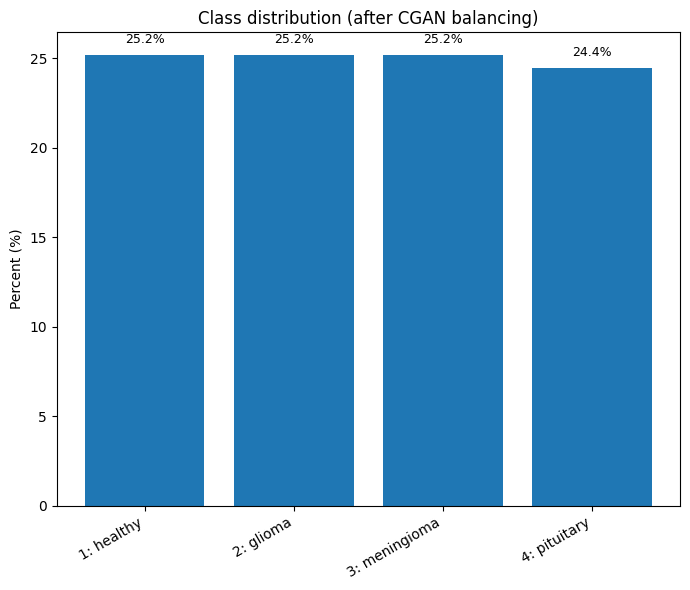

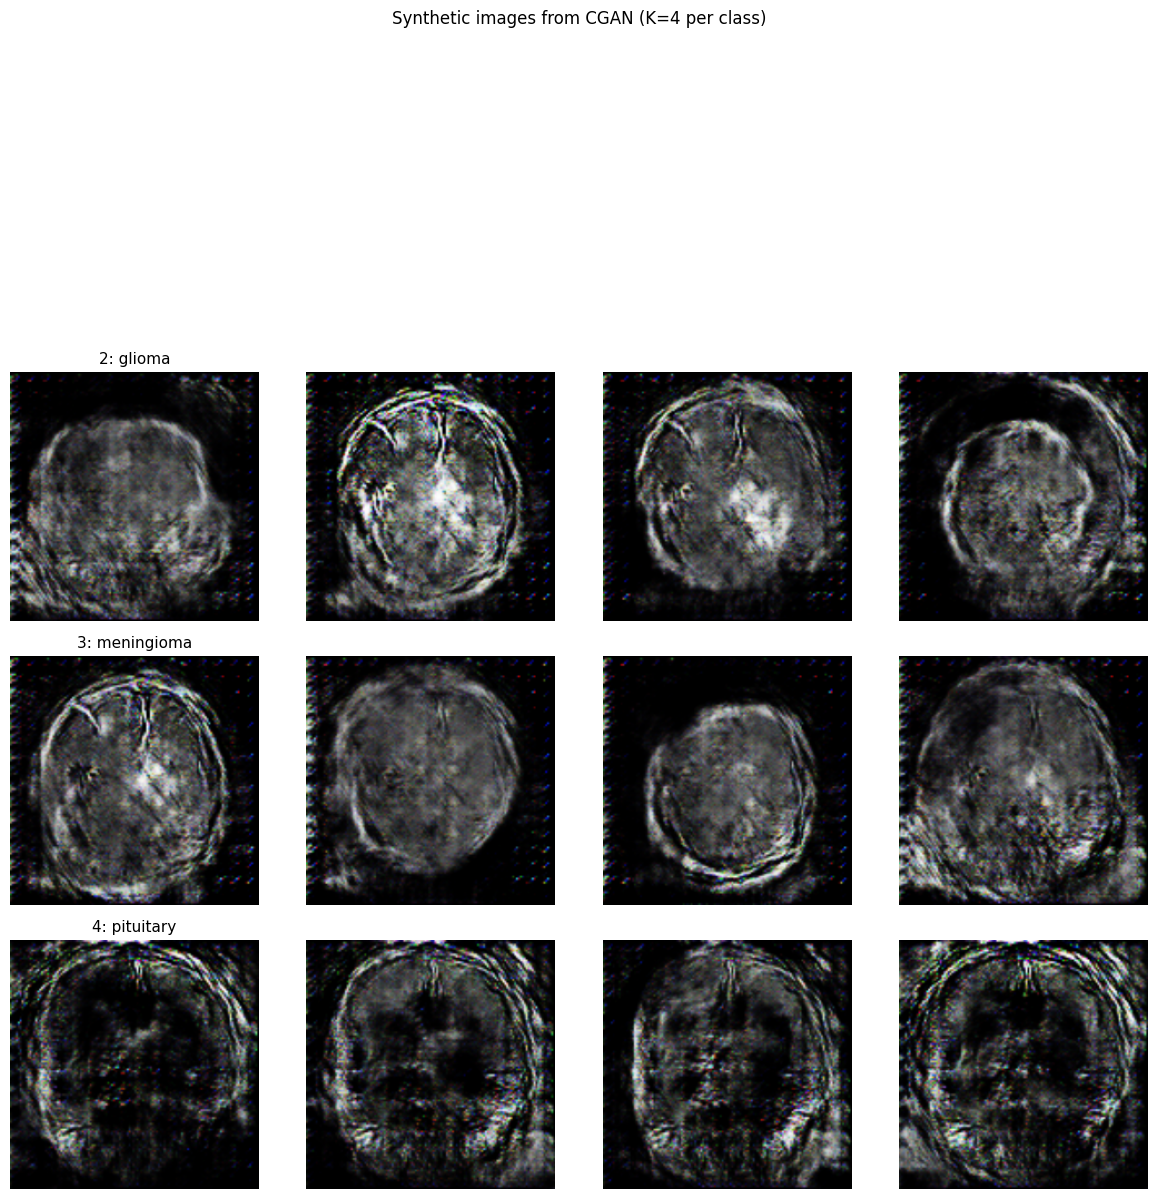

In [ ]:
#Run CGAN

AUG_IMG_DIR = CFG.WORK_DIR / 'aug_balanced'

if CFG.USE_CGAN:
    G = train_cgan(train_files, train_labels)
    synthesize_to_balance(G, AUG_IMG_DIR)
    merged_files = train_files[:] ; merged_labels = train_labels[:]
    for cls in classes:
        for p in sorted((AUG_IMG_DIR/cls).glob('*.png')):
            merged_files.append(p); merged_labels.append(cls)
else:
    merged_files, merged_labels = train_files, train_labels

# After-balance percentages table + bar chart
after_counts = pd.Series(merged_labels).value_counts().reindex(classes)
total_after = after_counts.sum()
pct_after = (after_counts / total_after * 100).round(2)

after_df = pd.DataFrame({
    "id": [class_to_id1[c] for c in classes],
    "class": classes,
    "count": after_counts.values,
    "percent": pct_after.values
})
print("Class distribution (after balancing):")
display(after_df)

labels = [f"{class_to_id1[c]}: {c}" for c in classes]
plt.figure(figsize=(7,6))
bars = plt.bar(labels, pct_after.values)
plt.title("Class distribution (after CGAN balancing)" if CFG.USE_CGAN else "Class distribution (no CGAN)")
plt.ylabel("Percent (%)")
plt.xticks(rotation=30, ha='right')
for b, v in zip(bars, pct_after.values):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()

# Show K synthetic images per class (if CGAN used)
if CFG.USE_CGAN:
    K = 4
    plt.figure(figsize=(3*K, 3*len(classes)))
    for r, cname in enumerate(classes):
        synth_files = sorted((AUG_IMG_DIR/cname).glob('*.png'))
        if len(synth_files)==0: continue
        sample = random.sample(synth_files, k=min(K, len(synth_files)))
        for ci, fp in enumerate(sample):
            ax = plt.subplot(len(classes), K, r*K + ci + 1)
            ax.imshow(Image.open(fp).convert('RGB')); ax.axis('off')
            if ci == 0: ax.set_title(f"{class_to_id1[cname]}: {cname}", fontsize=11)
    plt.suptitle(f"Synthetic images from CGAN (K={K} per class)", y=0.995)
    plt.tight_layout(rect=[0,0,1,0.97]); plt.show()


In [ ]:
#Final dataloaders

train_ds = ImageDataset(merged_files, merged_labels, train_tfms)
val_ds   = ImageDataset(val_files,    val_labels,    valid_tfms)

train_dl = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,  num_workers=CFG.NUM_WORKERS)
val_dl   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

print("Batches -> train:", len(train_dl), "| val:", len(val_dl))


Batches -> train: 707 | val: 77


In [ ]:
#Train/eval utilities

def train_one_epoch(model, dl, opt, criterion, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward(); opt.step()
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total   += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, dl, criterion, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_y = [], []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
        total    += x.size(0)
        all_logits.append(out.cpu()); all_y.append(y.cpu())
    logits = torch.cat(all_logits).numpy(); ys = torch.cat(all_y).numpy()
    return loss_sum/total, correct/total, logits, ys



In [ ]:
#Train one model + Curves + CM + ROC + Report

def train_model(model_name, timm_name):
    n_classes = len(classes)
    device = CFG.DEVICE
    model = timm.create_model(timm_name, pretrained=True, num_classes=n_classes).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=CFG.LR)
    criterion = nn.CrossEntropyLoss()

    tr_losses, val_losses, tr_accs, val_accs = [], [], [], []
    best_acc, best_path = 0.0, CFG.WORK_DIR / f"best_{model_name}.pt"

    for epoch in range(CFG.EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, criterion, device)
        val_loss, val_acc, logits, ys = evaluate(model, val_dl, criterion, device)
        tr_losses.append(tr_loss); val_losses.append(val_loss)
        tr_accs.append(tr_acc);   val_accs.append(val_acc)
        print(f"[{model_name}] Epoch {epoch+1}/{CFG.EPOCHS} | "
              f"train acc {tr_acc:.4f} loss {tr_loss:.4f} | "
              f"val acc {val_acc:.4f} loss {val_loss:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({'model': model.state_dict(), 'classes': classes}, best_path)

    # Curves
    epochs = range(1, CFG.EPOCHS + 1)
    plt.figure(figsize=(6,4))
    plt.plot(list(epochs), tr_losses, label='train')
    plt.plot(list(epochs), val_losses, label='val')
    plt.title(f'{model_name}: Loss'); plt.xlabel('epoch'); plt.ylabel('loss')
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(list(epochs), tr_accs, label='train')
    plt.plot(list(epochs), val_accs, label='val')
    plt.title(f'{model_name}: Accuracy'); plt.xlabel('epoch'); plt.ylabel('acc')
    plt.legend(); plt.tight_layout(); plt.show()

    # Confusion Matrix (healthy first)
    y_pred = np.argmax(logits, axis=1)
    cm = confusion_matrix(ys, y_pred, labels=np.arange(len(classes)))
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(5.5,4.5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_ids = np.arange(1, len(classes)+1)
    plt.xticks(np.arange(len(classes)), tick_ids)
    plt.yticks(np.arange(len(classes)), tick_ids)
    plt.xlabel("Predicted (ID)"); plt.ylabel("True (ID)")
    plt.title(f'{model_name}: Confusion Matrix')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    # ID → Class mapping
    print("ID → Class mapping (healthy first):")
    for i, c in enumerate(classes, start=1):
        print(f"{i}: {c}")

    #Classification Report
    print("\nClassification Report (healthy first):")
    print(classification_report(ys, y_pred, target_names=classes, digits=4))

    #ROC (OvR, healthy first)
    ys_bin = label_binarize(ys, classes=np.arange(len(classes)))
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    plt.figure(figsize=(6,5)); roc_aucs = {}
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(ys_bin[:, i], probs[:, i])
        roc_aucs[cls] = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_to_id1[cls]}: {cls} (AUC={roc_aucs[cls]:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title(f'{model_name}: ROC (OvR, healthy=1)')
    plt.legend(); plt.tight_layout(); plt.show()

    return best_acc, roc_aucs


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

[convnext_tiny] Epoch 1/20 | train acc 0.9061 loss 0.2430 | val acc 0.9656 loss 0.0949
[convnext_tiny] Epoch 2/20 | train acc 0.9723 loss 0.0827 | val acc 0.9861 loss 0.0444
[convnext_tiny] Epoch 3/20 | train acc 0.9837 loss 0.0525 | val acc 0.9881 loss 0.0386
[convnext_tiny] Epoch 4/20 | train acc 0.9855 loss 0.0455 | val acc 0.9853 loss 0.0456
[convnext_tiny] Epoch 5/20 | train acc 0.9861 loss 0.0421 | val acc 0.9865 loss 0.0392
[convnext_tiny] Epoch 6/20 | train acc 0.9878 loss 0.0376 | val acc 0.9914 loss 0.0324
[convnext_tiny] Epoch 7/20 | train acc 0.9915 loss 0.0274 | val acc 0.9881 loss 0.0436
[convnext_tiny] Epoch 8/20 | train acc 0.9909 loss 0.0305 | val acc 0.9857 loss 0.0533
[convnext_tiny] Epoch 9/20 | train acc 0.9905 loss 0.0281 | val acc 0.9930 loss 0.0275
[convnext_tiny] Epoch 10/20 | train acc 0.9917 loss 0.0246 | val acc 0.9877 loss 0.0427
[convnext_tiny] Epoch 11/20 | train acc 0.9914 loss 0.0257 | val acc 0.9930 loss 0.0268
[convnext_tiny] Epoch 12/20 | train acc 0

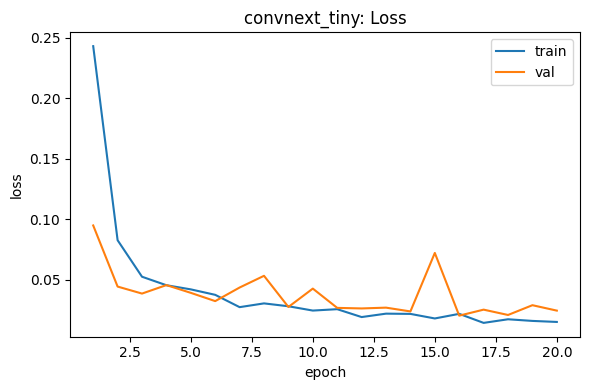

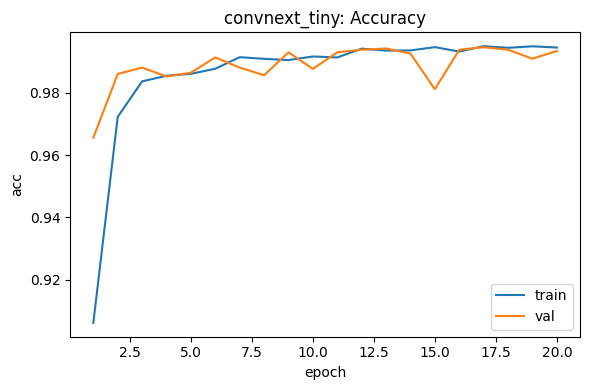

Confusion Matrix:
 [[1003    1    1    1]
 [   2  491    5    1]
 [   2    3  485    0]
 [   0    0    0  446]]


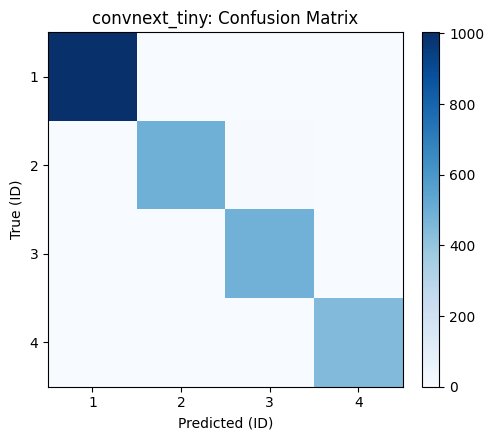

ID → Class mapping (healthy first):
1: healthy
2: glioma
3: meningioma
4: pituitary

Classification Report (healthy first):
              precision    recall  f1-score   support

     healthy     0.9960    0.9970    0.9965      1006
      glioma     0.9919    0.9840    0.9879       499
  meningioma     0.9878    0.9898    0.9888       490
   pituitary     0.9955    1.0000    0.9978       446

    accuracy                         0.9934      2441
   macro avg     0.9928    0.9927    0.9927      2441
weighted avg     0.9934    0.9934    0.9934      2441



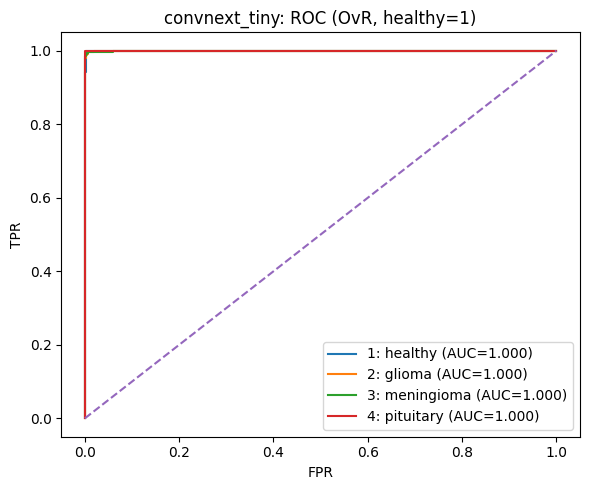

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

[coatnet] Epoch 1/20 | train acc 0.7746 loss 0.5207 | val acc 0.8046 loss 0.6320
[coatnet] Epoch 2/20 | train acc 0.9309 loss 0.1927 | val acc 0.9377 loss 0.1981
[coatnet] Epoch 3/20 | train acc 0.9537 loss 0.1326 | val acc 0.9271 loss 0.1923
[coatnet] Epoch 4/20 | train acc 0.9637 loss 0.1049 | val acc 0.9570 loss 0.1494
[coatnet] Epoch 5/20 | train acc 0.9713 loss 0.0882 | val acc 0.9713 loss 0.1093
[coatnet] Epoch 6/20 | train acc 0.9731 loss 0.0828 | val acc 0.9406 loss 0.1606
[coatnet] Epoch 7/20 | train acc 0.9761 loss 0.0713 | val acc 0.9680 loss 0.1042
[coatnet] Epoch 8/20 | train acc 0.9768 loss 0.0704 | val acc 0.9840 loss 0.0566
[coatnet] Epoch 9/20 | train acc 0.9806 loss 0.0588 | val acc 0.9873 loss 0.0470
[coatnet] Epoch 10/20 | train acc 0.9817 loss 0.0554 | val acc 0.9828 loss 0.0574
[coatnet] Epoch 11/20 | train acc 0.9820 loss 0.0552 | val acc 0.9746 loss 0.0690
[coatnet] Epoch 12/20 | train acc 0.9824 loss 0.0527 | val acc 0.9701 loss 0.1022
[coatnet] Epoch 13/20 | t

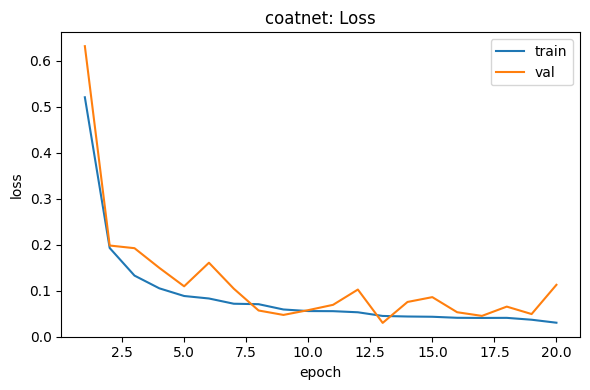

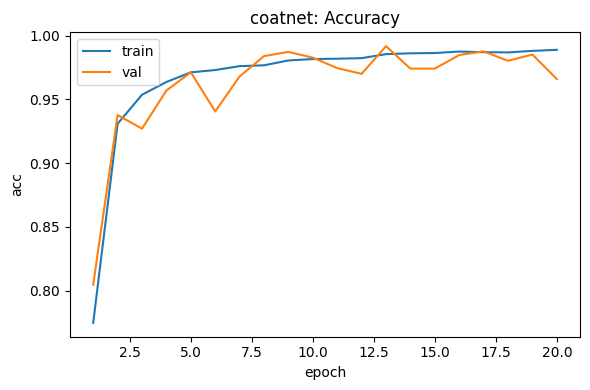

Confusion Matrix:
 [[1004    1    0    1]
 [  13  457   29    0]
 [  11    2  477    0]
 [   4    0   22  420]]


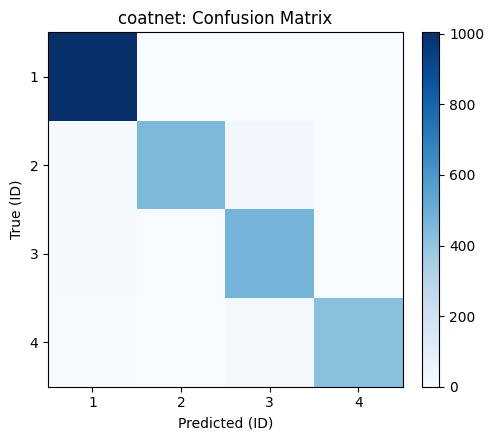

ID → Class mapping (healthy first):
1: healthy
2: glioma
3: meningioma
4: pituitary

Classification Report (healthy first):
              precision    recall  f1-score   support

     healthy     0.9729    0.9980    0.9853      1006
      glioma     0.9935    0.9158    0.9531       499
  meningioma     0.9034    0.9735    0.9371       490
   pituitary     0.9976    0.9417    0.9689       446

    accuracy                         0.9660      2441
   macro avg     0.9668    0.9573    0.9611      2441
weighted avg     0.9677    0.9660    0.9660      2441



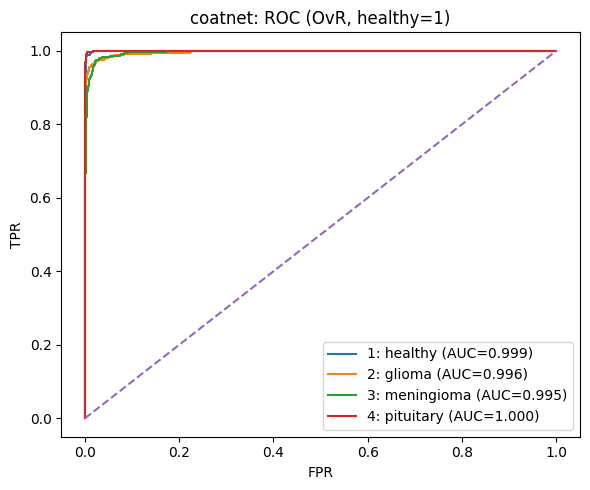

model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

[vit_resnet_hybrid] Epoch 1/20 | train acc 0.6396 loss 0.7767 | val acc 0.7681 loss 0.6218
[vit_resnet_hybrid] Epoch 2/20 | train acc 0.8247 loss 0.4403 | val acc 0.8591 loss 0.3765
[vit_resnet_hybrid] Epoch 3/20 | train acc 0.8852 loss 0.3004 | val acc 0.8701 loss 0.3215
[vit_resnet_hybrid] Epoch 4/20 | train acc 0.9184 loss 0.2293 | val acc 0.9209 loss 0.2064
[vit_resnet_hybrid] Epoch 5/20 | train acc 0.9359 loss 0.1799 | val acc 0.9152 loss 0.2384
[vit_resnet_hybrid] Epoch 6/20 | train acc 0.9450 loss 0.1529 | val acc 0.9066 loss 0.2711
[vit_resnet_hybrid] Epoch 7/20 | train acc 0.9498 loss 0.1399 | val acc 0.9472 loss 0.1340
[vit_resnet_hybrid] Epoch 8/20 | train acc 0.9574 loss 0.1219 | val acc 0.9574 loss 0.1123
[vit_resnet_hybrid] Epoch 9/20 | train acc 0.9610 loss 0.1076 | val acc 0.9517 loss 0.1449
[vit_resnet_hybrid] Epoch 10/20 | train acc 0.9671 loss 0.0988 | val acc 0.9680 loss 0.1002
[vit_resnet_hybrid] Epoch 11/20 | train acc 0.9677 loss 0.0942 | val acc 0.9644 loss 0.10

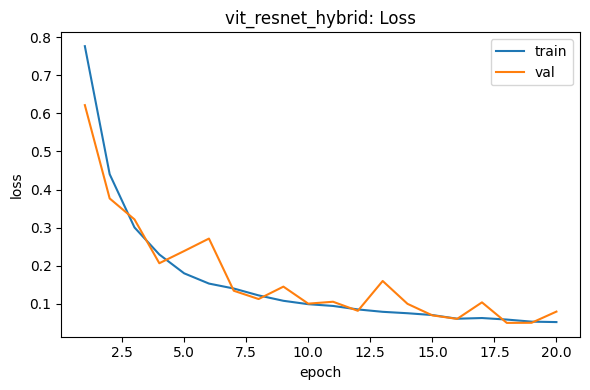

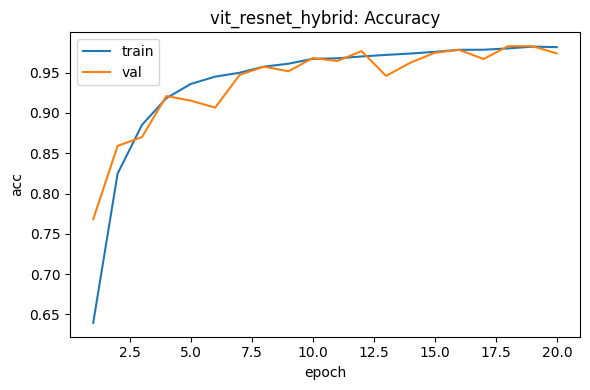

Confusion Matrix:
 [[1001    3    2    0]
 [   7  469   22    1]
 [  14    3  469    4]
 [   5    2    1  438]]


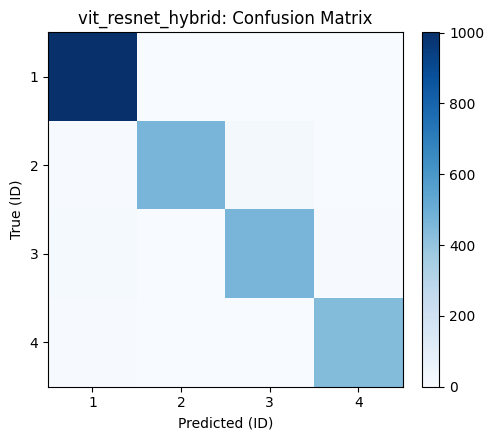

ID → Class mapping (healthy first):
1: healthy
2: glioma
3: meningioma
4: pituitary

Classification Report (healthy first):
              precision    recall  f1-score   support

     healthy     0.9747    0.9950    0.9848      1006
      glioma     0.9832    0.9399    0.9611       499
  meningioma     0.9494    0.9571    0.9533       490
   pituitary     0.9887    0.9821    0.9854       446

    accuracy                         0.9738      2441
   macro avg     0.9740    0.9685    0.9711      2441
weighted avg     0.9739    0.9738    0.9737      2441



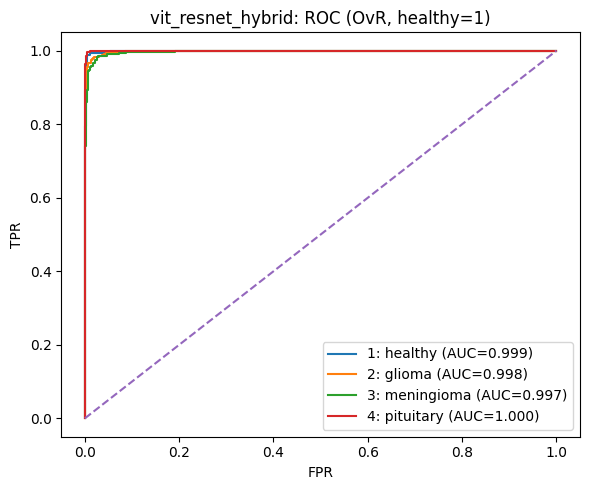


Summary:
{
  "convnext_tiny": {
    "best_val_acc": 0.9946743138058173,
    "roc_auc": {
      "healthy": 0.9998344428204293,
      "glioma": 0.9998472743633507,
      "meningioma": 0.9995543886442326,
      "pituitary": 0.9999921327983636
    }
  },
  "coatnet": {
    "best_val_acc": 0.9918066366243343,
    "roc_auc": {
      "healthy": 0.9994229743490278,
      "glioma": 0.9964800868472269,
      "meningioma": 0.9953461856295568,
      "pituitary": 0.9998808680895064
    }
  },
  "vit_resnet_hybrid": {
    "best_val_acc": 0.9827939369111021,
    "roc_auc": {
      "healthy": 0.998999729843933,
      "glioma": 0.9982519106183532,
      "meningioma": 0.9966913879852299,
      "pituitary": 0.9997740989244412
    }
  }
}
All done. Artifacts saved to: /kaggle/working


In [ ]:
#Train all models + save artifacts

results = {}
for model_name, timm_name in CFG.MODELS:
    acc, rocs = train_model(model_name, timm_name)
    results[model_name] = {'best_val_acc': float(acc), 'roc_auc': {k: float(v) for k,v in rocs.items()}}

print("\nSummary:")
print(json.dumps(results, indent=2))

with open(CFG.WORK_DIR / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

with open(CFG.WORK_DIR / 'classes.json', 'w') as f:
    json.dump({'class_to_idx': class_to_idx, 'classes': classes}, f, indent=2)

print("All done. Artifacts saved to:", CFG.WORK_DIR)


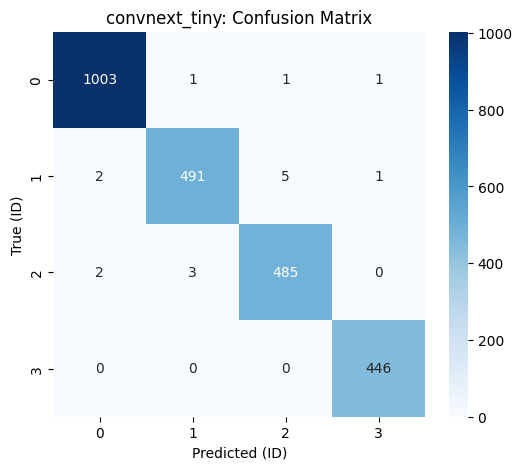

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example confusion matrix (replace with yours)
cm = [[1003, 1, 1, 1],
      [2, 491, 5, 1],
      [2, 3, 485, 0],
      [0, 0, 0, 446]]

# Plot with seaborn heatmap and annotations
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.title("convnext_tiny: Confusion Matrix")
plt.xlabel("Predicted (ID)")
plt.ylabel("True (ID)")
plt.show()


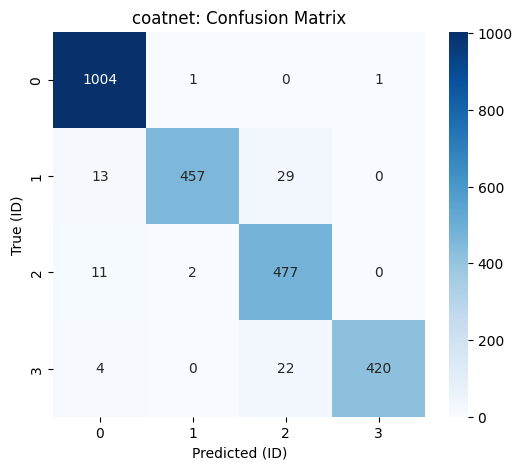

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example confusion matrix (replace with yours)
cm = [[1004, 1, 0, 1],
      [13, 457, 29, 0],
      [11, 2, 477, 0],
      [4, 0, 22, 420]]

# Plot with seaborn heatmap and annotations
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.title("coatnet: Confusion Matrix")
plt.xlabel("Predicted (ID)")
plt.ylabel("True (ID)")
plt.show()


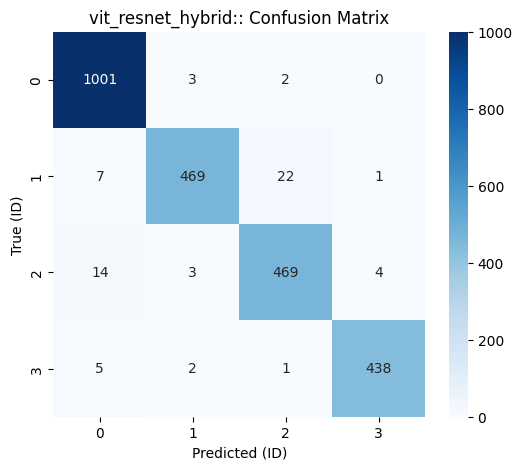

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example confusion matrix (replace with yours)
cm = [[1001, 3, 2, 0],
      [7, 469, 22, 1],
      [14, 3, 469, 4],
      [5, 2, 1, 438]]

# Plot with seaborn heatmap and annotations
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.title("vit_resnet_hybrid:: Confusion Matrix")
plt.xlabel("Predicted (ID)")
plt.ylabel("True (ID)")
plt.show()
